# Extended Kalman Filter Localization
## Timothy Devon Morris
### Extended Kalman Filter

In estimation theory, the extended Kalman filter (EKF) is the nonlinear version of the Kalman filter which linearizes about an estimate of the current mean and covariance. In the case of well defined transition models, the EKF has been considered the de facto standard in the theory of nonlinear state estimation, navigation systems and GPS.

In this notebook, we will solve the localization problem with a two wheeled mobile robot, fixed landmark locations and known correspondences between measurments and landmarks.

In [1]:
from __future__ import division
import numpy as np
import numpy.linalg as la
import scipy.linalg as sla
from IPython.display import display,HTML
import matplotlib.pyplot as plt
from matplotlib import animation,rc
import seaborn

### Robot Motion Class
Our 2D robot has a state vector consisting of $(x, y , \theta)^T$. We assume that our robot follows a nonlinear dynamics model implemented with a velocity controller on $v$ and $\omega$. Together $(v,\omega)^T = u$. Thus,
$\mathbf{x}_t = f(\mathbf{x}_{t-1},u)$
where

$$f(\mathbf{x}_{t-1},u) = 
\begin{bmatrix}
x_{t-1} \\
y_{t-1} \\
\theta_{t-1}
\end{bmatrix} + 
\begin{bmatrix}
-\frac{v}{\omega}\sin{\theta_{t-1}} + \frac{v}{\omega}\sin{(\theta_{t-1} + \omega \Delta t)} \\
\frac{v}{\omega}\cos{\theta_{t-1}} - \frac{v}{\omega}\cos{(\theta_{t-1} + \omega \Delta t)} \\
\omega \Delta t
\end{bmatrix}$$

We assume that with our control input $u$ we have associated noise 

$$
\begin{bmatrix}
\hat{v} \\
\hat{\omega}
\end{bmatrix} =
\begin{bmatrix}
v \\
\omega
\end{bmatrix}
+ 
\begin{bmatrix}
\varepsilon_{\alpha_1 v^2 + \alpha_2 \omega^2} \\
\varepsilon_{\alpha_3 v^2 + \alpha_4 \omega^2}
\end{bmatrix}$$

where $\varepsilon_{b^2} \sim \mathcal{N}(0,b^2)$

Note: the velocity motion model doesn't work for straight line motion, this is because we divide by $\omega$.


In [2]:
class VCRobot(object):
    '''
    Class to implement a velocity controlled two-wheeled robot
    
    The robot has state (x, y, theta) 
    The motion model is described in Probabilistic Robotics by Thrun ch. 5d
    '''
    def __init__(self, dt, alpha):
        '''
        member variables:
        dt - time step
        alpha - numpy array (4) describing noise characteristics
        '''
        self.dt = dt
        self.alpha = alpha
    
    def generate_motion(self,v,w,x0):
        '''
        inputs:
        v - numpy array (T) describing velocity
        w - numpy array (T) describing angular velocity
        x0 - numpy array (3) describing initial position
        
        outputs:
        X - numpy array (T,3) describing state at each time step
        '''
        dt = self.dt
        alpha = self.alpha
        T = len(v)
        
        X = np.zeros((T+1,3))
        X[0,:] = x0
        
        for t in xrange(T):
            var1 = alpha[0]*v[t]**2 + alpha[1]*w[t]**2
            var2 = alpha[2]*v[t]**2 + alpha[3]*w[t]**2
            v_hat = v[t] + np.sqrt(var1)*np.random.randn()
            w_hat = w[t] + np.sqrt(var2)*np.random.randn()
            stheta = np.sin(X[t,2])
            ctheta = np.cos(X[t,2])
            sthetap = np.sin(X[t,2] + dt*w_hat)
            cthetap = np.cos(X[t,2] + dt*w_hat)
            
            X[t+1,0] = X[t,0] - v_hat/w_hat*stheta + v_hat/w_hat*sthetap
            X[t+1,1] = X[t,1] + v_hat/w_hat*ctheta - v_hat/w_hat*cthetap
            X[t+1,2] = X[t,2] + w_hat*dt
        
        return X
        
class LocalizationAnimation(object):
    '''
    Class to visualize the 2D localization problem for a two-wheeled robot
    
    The robot has state (x, y, theta)
    The motion model is described in Probabilistic Robotics by Thrun ch. 5d
    '''
    def __init__(self, X, Y,dt):
        '''
        member variables:
        X - numpy array (T,3) state of the robot
        Y - numpy array (m,2) Locations of landmarks
        '''
        self.X = X
        self.Y = Y
        self.dt = dt
    
    def animate(self):
        '''
        X - numpy array (3,T) describing state at each time step
        '''
        X = self.X
        Y = self.Y
        dt = self.dt
        T = X.shape[0]
        
        xm = -20
        xM = 20
        ym = -20
        yM = 20
        
        env = plt.figure(figsize=(8, 8))
        ax = env.add_subplot(1, 1, 1)
        ax.set_xlim((xm, xM))
        ax.set_ylim((ym, yM))
        ax.set_title("Robot Environment",fontsize=20)
        ax.set_xlabel("X position (m)", fontsize=16)
        ax.set_ylabel("Y position (m)", fontsize=16)
        
        robot = plt.Circle((X[0, 0], X[0, 1]), 1, fill=False)
        ax.add_artist(robot)
        direction = np.array([[0, np.cos(X[0, 2])], [0, np.sin(X[0, 2])]])
        line, = ax.plot(X[0, 0] + direction[0, :], X[1, 0] + direction[1, :], 'k')
        features, = ax.plot(Y[:, 0], Y[:, 1], 'gD')

        def animate(i):
            direction = np.array([[0, np.cos(X[i, 2])], [0, np.sin(X[i, 2])]])
            line.set_data(X[i, 0] + direction[0, :], X[i, 1] + direction[1, :])
            robot.center = X[i, 0], X[i, 1]
            return (line,)
        
        anim = animation.FuncAnimation(env, animate, frames=T, interval=dt*500, blit=True)
        return anim

In [3]:
dt = .1
alpha = np.array([.1, .01, .01, .1])
t = np.arange(0,20.1, dt)
x0 = np.array([-5, -3, np.pi/2])
Y = np.array([[6., 4.],
              [-7., 8.],
              [6., -4]])
R = np.array([[.01, .0],
              [0., .0025]])

v = 1 + .5*np.cos(.4*np.pi*t)
w = -.2 + 2*np.cos(1.2*np.pi*t)
robot = VCRobot(dt, alpha)
X = robot.generate_motion(v,w,x0)
ani = LocalizationAnimation(X,Y,dt)
HTML(ani.animate().to_html5_video())

### Landmarks
As seen in the plot above, we assume there are a number of stationary landmarks from which the robot can take range and bearing measurements. Since these landmarks have fixed position, we can use these measurements to determine our location and bearing. For each landmark $m$ we have an associated $\mathbf{x}_m = (x_m, y_m)^T$ denoting it's position. Since range is a norm and the bearing uses arctangent, this measurement model is inherently nonlinear. We denote this by
$\mathbf{z}_{t,m} = h(\mathbf{x}_{t}, \mathbf{x}_{m}, u)$.
Explicitly,

$$h(\mathbf{x}_t, \mathbf{x}_m, u) = 
\begin{bmatrix}
\sqrt{(x_m - x_t)^2 + (y_m - y_t)^2} \\
\arctan2{\frac{y_m - y_t}{x_m - x_t}}
\end{bmatrix}
$$

Note: In this case and many others, our measurement model does not directly depend on our control input $u$.

In [4]:
class LandmarkSensor(object):
    '''
    Class to simulate a landmark sensor
    This is a basic range-bearing sensor in 2D
    '''
    
    def __init__(self, Y, R):
        '''
        member variables:
        Y - numpy array (m, 2) locations of the landmarks
        R - noise covariance associated with range and bearing
        '''
        self.Y = Y
        self.R = R
        
    def simulate(self, X):
        '''
        inputs:
        X - numpy array (T,3) of vehicle state (x,y, theta)
        
        outputs:
        Z - numpy array (T,2*m) of range/bearing measurements
        '''
        Y = self.Y
        m, _ = Y.shape
        T, _ = X.shape
        
        Z = np.zeros((T,2*m))
        
        for i in xrange(m):
            Z[:, 2*i] = np.linalg.norm(X[:, 0:2] - self.Y[i,:], axis=1)
            Z[:, 2*i+1] = np.arctan2(self.Y[i,1] - X[:,1], self.Y[i,0] - X[:,0]) - X[:,2]
            
        for t in xrange(T):
            for i in xrange(m):
                Z[t, 2*i:2*i+2] += np.random.multivariate_normal(np.zeros(2), self.R)  
        return Z

In [5]:
rbsensor = LandmarkSensor(Y,R)
Z = rbsensor.simulate(X[1:,:])

### Extended Kalman Fitler Class
The Extended Kalman Filter works very similarly to the vanilla Kalman Filter. Like the KF, the EKF is divided into two steps: predict and update. First, however, have to linearize our model. Thus we define 3 matrices (the jacobians) given by

$$ F = \frac{\partial f}{\partial x}$$

$$ G = \frac{\partial f}{\partial u}$$

$$ H = \frac{\partial h}{\partial x}$$

#### Predict
$$\bar{\mu} = f(\mu_{t-1}, u_t)$$

$$\bar{\Sigma}_t = F_t\Sigma_{t-1}F_t^T + G_tQ_tG_t^T$$

#### Update
This update is done for each landmark

$$K_t = \bar{\Sigma}_tH_t^T(H_t\bar{\Sigma}_tH_t^T + R_t)^{-1}$$

$$\mu_t = \bar{\mu}_t + K_t(z_t - h(\bar{\mu}_t,\mathbf{x}_m,u))$$

$$\Sigma_t = (I - K_tH_t)\bar{\Sigma}_t$$

In [6]:
class EKF(object):
    '''
    Class to implement an Extended Kalman Filter
    for a system with noise on control inputs
    '''
    
    def __init__(self,f,h,F,G,H,Q,R):
        '''
        Class Variables:
        f(x,u) - function handle nonlinear state transition
        h(x,u) - function handle nonlinear measurement model
        F(x,u) - function handle Jacobian of state w/ respect to state
        G(x,u) - function handle Jacobian of state w/ respect to input
        H(x,u) - function handle Jacobian of measurement w/ respect to state
        Q(u) - function handle Covariance of input
        R - numpy matrix (mxm) sensor noise covariance
        '''
        self.f = f
        self.h = h
        self.F = F
        self.G = G
        self.H = H
        self.Q = Q
        self.R = R
    
    def filter(self,Z,U,Y,x0):
        '''
        Filters over a fixed number of time steps
        
        Inputs:
        Z - numpy matrix (Txm) measurements for T time steps
        U - numpy matrix (Txk) controls for T time steps
        x0 - numpy matrix (nx1) initial guess of position
        
        Outputs:
        X - numpy matrix (Txn) 
        '''
        n = x0.shape[0]
        T,m = Z.shape
        X = np.zeros((T+1,n))
        C = np.zeros((T+1,3))
        X[0,:] = x0
        G = self.G(X[0],U[0])
        Cov = 10*G*self.Q(U[0])*G.T
        C[0,:] = np.diag(Cov)
        for t, u in enumerate(U):
            # Prediction
            mu = self.f(X[t],u)
            F = self.F(X[t],u)
            G = self.G(X[t],u)
            Cov = F*Cov*F.T + G*self.Q(u)*G.T

            #Measurement Update
            for i in xrange(m//2):
                y = Y[i,:]
                z_hat = self.h(mu,y,u)
                H = self.H(mu,y,u)
                K = Cov*H.T*(la.inv(H*Cov*H.T + self.R))
                Zt = Z[t,2*i:2*i+2].reshape(2,1)
                innovation = Zt - z_hat
                mu += K*innovation
                Cov = (np.eye(n) - K*H)*Cov
            C[t+1,:] = np.diag(Cov)
            X[t+1] = mu.flatten()
        
        return X, C

In [7]:
def f(x,u):
    xp = np.matrix(np.zeros_like(x)).T
    v = u[0]
    w = u[1]
    stheta = np.sin(x[2])
    ctheta = np.cos(x[2])
    sthetap = np.sin(x[2] + dt*w)
    cthetap = np.cos(x[2] + dt*w)

    xp[0] = x[0] - v/w*stheta + v/w*sthetap
    xp[1] = x[1] + v/w*ctheta - v/w*cthetap
    xp[2] = x[2] + w*dt
    return xp

def h(x,y,u):
    m, _ = Y.shape
    zp = np.matrix(np.zeros(2)).T
    
    zp[0] = np.linalg.norm(x[0:2].T - y)
    zp[1] = np.arctan2(y[1] - x[1], y[0] - x[0]) - x[2]
    return zp

def F(x,u):
    n = x.shape[0]
    v = u[0]
    w = u[1]
    stheta = np.sin(x[2])
    ctheta = np.cos(x[2])
    sthetap = np.sin(x[2] + dt*w)
    cthetap = np.cos(x[2] + dt*w)
    
    F = np.matrix(np.eye(n))
    F[0,2] = -v/w*ctheta + v/w*cthetap
    F[1,2] = -v/w*stheta + v/w*sthetap
    return F
    
def G(x,u):
    n = x.shape[0]
    k = u.shape[0]
    v = u[0]
    w = u[1]
    stheta = np.sin(x[2])
    ctheta = np.cos(x[2])
    sthetap = np.sin(x[2] + dt*w)
    cthetap = np.cos(x[2] + dt*w)
    
    G = np.matrix(np.zeros((n,k)))
    G[0,0] = (-stheta + sthetap)/w
    G[0,1] = v*(stheta-sthetap)/(w**2) + v*(ctheta*dt)/w
    G[1,0] = (ctheta - cthetap)/w
    G[1,1] = -v*(ctheta - cthetap)/(w**2) + v*(stheta*dt)/w
    G[2,1] = dt
    return G

def H(x,y,u):
    m, _ = Y.shape
    n = x.shape[0]
    H = np.matrix(np.zeros((2,n)))
    q = (y[0] - x[0])**2 + (y[1] - x[1])**2
    sq = np.sqrt(q)
    H[0,0] = -(y[0] - x[0])/sq
    H[0,1] = -(y[1] - x[1])/sq
    H[1,0] = (y[1] - x[1])/q
    H[1,1] = -(y[0] - x[0])/q
    H[1,2] = -1
    return H

def Qt(u):
    k = u.shape[0]
    v = u[0]
    w = u[1]
    Q = np.matrix(np.zeros((k,k)))
    Q[0,0] = alpha[0]*v**2 + alpha[1]*w**2
    Q[1,1] = alpha[2]*v**2 + alpha[3]*w**2
    return Q
#x0 = np.array([0. ,0., 0.])
U = np.column_stack([v, w])
x0 = np.array([-5, -3, np.pi/2])

ekf = EKF(f,h,F,G,H,Qt,R)

In [8]:
X_hat, C = ekf.filter(Z,U,Y,x0)

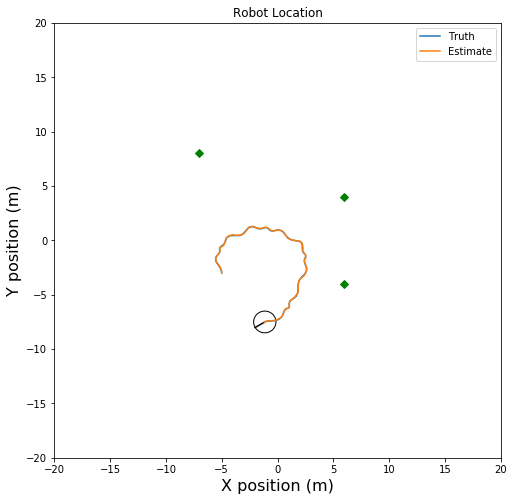

In [9]:
plt.plot(X[:,0],X[:,1],label="Truth")
plt.plot(X_hat[:,0], X_hat[:,1],label="Estimate")
plt.title("Robot Location")
plt.legend()
plt.show()

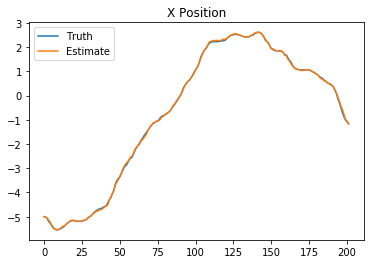

In [10]:
plt.plot(X[:,0],label="Truth")
plt.plot(X_hat[:,0],label="Estimate")
plt.title("X Position")
plt.legend()
plt.show()

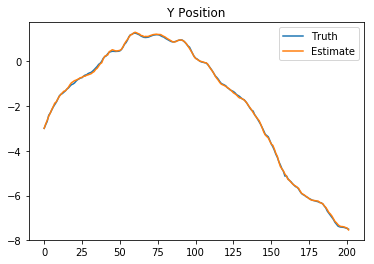

In [11]:
plt.plot(X[:,1],label="Truth")
plt.plot(X_hat[:,1],label="Estimate")
plt.title("Y Position")
plt.legend()
plt.show()

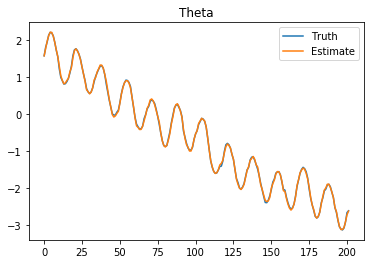

In [12]:
plt.plot(X[:,2],label="Truth")
plt.plot(X_hat[:,2],label="Estimate")
plt.title("Theta")
plt.legend()
plt.show()

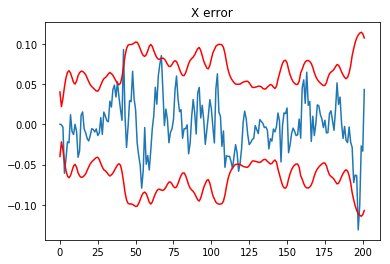

In [13]:
plt.plot(X[:,0]-X_hat[:,0])
plt.plot(2*np.sqrt(C[:,0]), color='r')
plt.plot(- 2*np.sqrt(C[:,0]), color='r')
plt.title("X error")
plt.show()

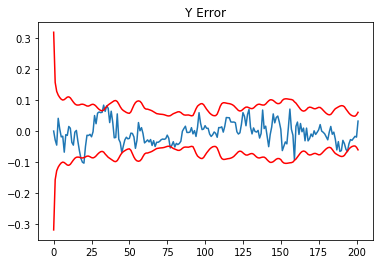

In [14]:
plt.plot(X[:,1]-X_hat[:,1])
plt.plot(2*np.sqrt(C[:,1]), color='r')
plt.plot(- 2*np.sqrt(C[:,1]), color='r')
plt.title("Y Error")
plt.show()

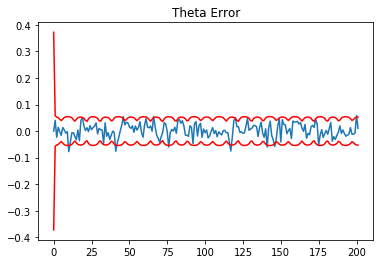

In [15]:
plt.plot(X[:,2]-X_hat[:,2])
plt.plot(2*np.sqrt(C[:,2]), color='r')
plt.plot(- 2*np.sqrt(C[:,2]), color='r')
plt.title("Theta Error")
plt.show()